<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/lcl_trst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

In [4]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/jeju/201901-202003.csv')
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [5]:
# project_id = 'jeju-bigquery-282708'
# client = bigquery.Client(project=project_id)

# train = client.query('''
#   SELECT 
#       * 
#   FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
#   WHERE RAND() < 10000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
#   ''').to_dataframe()

In [6]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [7]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
data['REG_YYMM'].head()

0    201901
1    201901
2    201901
3    201901
4    201901
Name: REG_YYMM, dtype: int64

In [8]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [9]:
local = data[data['CARD_CCG_NM']==data['HOM_CCG_NM']].reset_index(drop=True)
tourist = data[data['CARD_CCG_NM']!=data['HOM_CCG_NM']].reset_index(drop=True)

In [10]:
# 데이터 정제
data = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
data = data.groupby(columns).sum().reset_index(drop=False)

In [11]:
# 데이터 정제
local = local.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
local = local.groupby(columns).sum().reset_index(drop=False)

In [12]:
# 데이터 정제
tourist = tourist.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
tourist = tourist.groupby(columns).sum().reset_index(drop=False)

In [13]:
# 인코딩
dtypes = data.dtypes
encoders = {}
for column in data.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(data[column])
        encoders[column] = encoder
        
data_num = data.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    data_num[column] = encoder.transform(data[column])

In [14]:
# 인코딩
dtypes_lcl = local.dtypes
encoders = {}
for column in local.columns:
    if str(dtypes_lcl[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(local[column])
        encoders[column] = encoder
        
data_num_lcl = local.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    data_num_lcl[column] = encoder.transform(local[column])

In [15]:
# 인코딩
dtypes_trst = tourist.dtypes
encoders = {}
for column in tourist.columns:
    if str(dtypes_lcl[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(tourist[column])
        encoders[column] = encoder
        
data_num_trst = tourist.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    data_num_trst[column] = encoder.transform(tourist[column])

In [16]:
train_lcl, test_lcl = data_num_lcl[local['year']!=2020], data_num_lcl[data_num_lcl['year']==2020]
train_trst, test_trst = data_num_trst[tourist['year']!=2020], data_num_trst[data_num_trst['year']==2020]

In [17]:
X_train_lcl, y_train_lcl = train_lcl.loc[:, train_lcl.columns != 'AMT'], train_lcl['AMT']
X_test_lcl, y_test_lcl = test_lcl.loc[:, test_lcl.columns != 'AMT'], test_lcl['AMT']
X_train_lcl, X_test_lcl = X_train_lcl.drop(['CSTMR_CNT', 'CNT'], axis=1), X_test_lcl.drop(['CSTMR_CNT', 'CNT'], axis=1)

X_train_trst, y_train_trst = train_trst.loc[:, train_trst.columns != 'AMT'], train_trst['AMT']
X_test_trst, y_test_trst = test_trst.loc[:, test_trst.columns != 'AMT'], test_trst['AMT']
X_train_trst, X_test_trst = X_train_trst.drop(['CSTMR_CNT', 'CNT'], axis=1), X_test_trst.drop(['CSTMR_CNT', 'CNT'], axis=1)

In [18]:
y_train_lcl, y_train_trst = np.log1p(y_train_lcl), np.log1p(y_train_trst)


 mu = 15.82 and sigma = 2.83



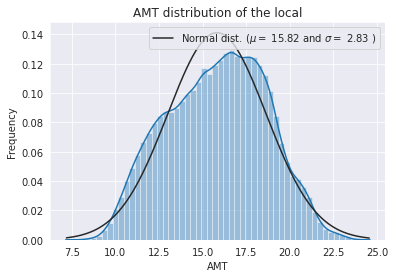

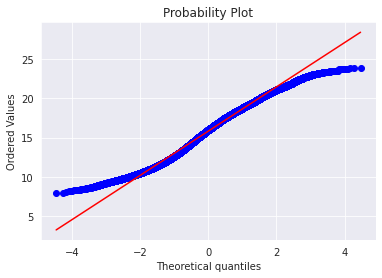

In [19]:
sns.distplot(y_train_lcl, fit=norm);
(mu, sigma) = norm.fit(y_train_lcl)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution of the local')

fig = plt.figure()
res = stats.probplot(y_train_lcl, plot=plt)
plt.show()


 mu = 15.82 and sigma = 2.83



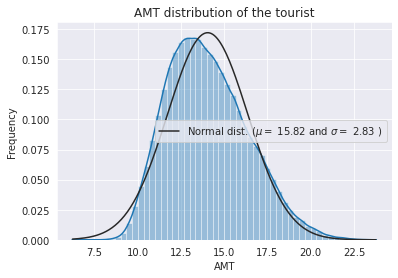

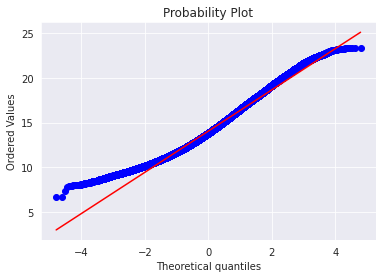

In [20]:
sns.distplot(y_train_trst, fit=norm);
(mu, sigma) = norm.fit(y_train_lcl)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution of the tourist')

fig = plt.figure()
res = stats.probplot(y_train_trst, plot=plt)
plt.show()

In [21]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

In [22]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [23]:
# 교차검증 수행
def lcl_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train_lcl, y_train_lcl)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test_lcl)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test_lcl, eval_pred)
  
  return cv_model.best_estimator_

In [24]:
# 교차검증 수행
def trst_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train_trst, y_train_trst)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test_trst)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test_trst, eval_pred)
  
  return cv_model.best_estimator_

In [25]:
from sklearn.linear_model import LinearRegression

# 4개의 모델 선언
# random_state = 0 <- 이 숫자는 아무거나 적어도 상관 X
# xgb gbm lgb 모두 'random_state=0' <- 모두 같은 데이터로 모델링
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models = []
for model in models:
  new_model = lcl_best_params_model(model=model, params=params)
  best_models.append(new_model)

[08:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [26]:
# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test_lcl)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(X_test_lcl)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(X_test_lcl)
lgb_pred = np.expm1(lgb_pred)

pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

(3, 41596)
(41596, 3)


In [27]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
rmsle(y_test_lcl, final)

Test Data RMSLE: 1.043


In [28]:
from itertools import product

# 예측 템플릿 만들기
CARD_SIDO_NMs = data_num_lcl['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = data_num_lcl['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = data_num_lcl['HOM_SIDO_NM'].unique()
AGEs          = data_num_lcl['AGE'].unique()
SEX_CTGO_CDs  = data_num_lcl['SEX_CTGO_CD'].unique()
FLCs          = data_num_lcl['FLC'].unique()
years         = [2020]
months        = [1, 2, 3]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs, HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = data_num_lcl.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [29]:
# 예측 데이터 세트
xgb_pred = xgb_reg.predict(temp)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(temp)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(temp)
lgb_pred = np.expm1(lgb_pred)

In [30]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20

temp['AMT'] = np.round(final, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [31]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

temp.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202001,강원,건강보조식품 소매업,1.675132e+09
1,202001,강원,골프장 운영업,2.123215e+09
2,202001,강원,과실 및 채소 소매업,8.349449e+09
3,202001,강원,관광 민예품 및 선물용품 소매업,9.343965e+07
4,202001,강원,그외 기타 분류안된 오락관련 서비스업,4.925626e+07


In [35]:
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202001,강원,건강보조식품 소매업,1.675132e+09
1,202001,강원,골프장 운영업,2.123215e+09
2,202001,강원,과실 및 채소 소매업,8.349449e+09
3,202001,강원,관광 민예품 및 선물용품 소매업,9.343965e+07
4,202001,강원,그외 기타 분류안된 오락관련 서비스업,4.925626e+07
...,...,...,...,...
2086,202003,충북,피자 햄버거 샌드위치 및 유사 음식점업,7.831204e+09
2087,202003,충북,한식 음식점업,1.016263e+11
2088,202003,충북,호텔업,3.392842e+08
2089,202003,충북,화장품 및 방향제 소매업,4.032839e+09


In [37]:
pd.options.display.float_format = '{:.2f}'.format

In [38]:
temp

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202001,강원,건강보조식품 소매업,1675132300.00
1,202001,강원,골프장 운영업,2123215309.00
2,202001,강원,과실 및 채소 소매업,8349449423.00
3,202001,강원,관광 민예품 및 선물용품 소매업,93439652.00
4,202001,강원,그외 기타 분류안된 오락관련 서비스업,49256256.00
...,...,...,...,...
2086,202003,충북,피자 햄버거 샌드위치 및 유사 음식점업,7831204435.00
2087,202003,충북,한식 음식점업,101626326814.00
2088,202003,충북,호텔업,339284158.00
2089,202003,충북,화장품 및 방향제 소매업,4032839140.00


전체 데이터를 통해 거주민의 2020년 1월 ~ 2020년 3월을 예측.

예측 데이터이기 때문에 모든 지역, 모든 업종에 대한 예측값이 존재.

실제 데이터엔 몇몇 업종에 대한 값이 존재하지 않음.

다른 노트에서 확인한 실제 202001 ~ 202003 데이터와 비교하면, 그 값의 차이가 생각보다 많이 남. 증감률이 무의미할 정도로 차이가 많이 남.

만약 코로나로 인한 결과치라면, 2019년 데이터로 2020년 데이터를 학습하는 것이 아닌, 다른 방법을 모색해보는 것이 중요할듯.

In [39]:
len(temp[temp['REG_YYMM'] == 202001])

697

In [40]:
len(temp[temp['REG_YYMM'] == 202002])

697

In [41]:
len(temp[temp['REG_YYMM'] == 202003])

697

In [42]:
len(temp['STD_CLSS_NM'].unique())

41

In [43]:
len(temp['CARD_SIDO_NM'].unique())

17

확인 결과, 업종의 종류가 41개, 카드 이용처(시도 기준)가 17개. 따라서 41 X 17 =  697개 만큼의 예측값이 발생.